## Inference Pipeline

For inference we instantiate the same neural modules but now we will be using the checkpoints that we just learned.

In [1]:
import nemo
import nemo_nlp
from pytorch_transformers import BertTokenizer
import torch
import torch.nn.functional as f


import math
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = -1

import json

import preproc_data_layer

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")


In [2]:
pretrained_bert_model = 'bert-base-uncased'
#pretrained_bert_model = 'bert-large-uncased'
bert_model_config_path = pretrained_bert_model + '_config.json'
checkpoint_dir = 'checkpoints_' + pretrained_bert_model
inference_log_dir = 'inference_' + pretrained_bert_model
data_dir = 'data/SST-2'

In [3]:
!ls -lh $checkpoint_dir

total 3.7G
-rw-r--r-- 1 root root 418M Jan 16 22:24 BERT-EPOCH-1.pt
-rw-r--r-- 1 root root 418M Jan 16 22:25 BERT-EPOCH-2.pt
-rw-r--r-- 1 root root 418M Jan 17 05:46 BERT-EPOCH-3.pt
-rw-r--r-- 1 root root 2.3M Jan 16 22:24 SequenceClassifier-EPOCH-1.pt
-rw-r--r-- 1 root root 2.3M Jan 16 22:25 SequenceClassifier-EPOCH-2.pt
-rw-r--r-- 1 root root 2.3M Jan 17 05:46 SequenceClassifier-EPOCH-3.pt
-rw-r--r-- 1 root root 836M Jan 16 22:24 trainer-EPOCH-1.pt
-rw-r--r-- 1 root root 836M Jan 16 22:25 trainer-EPOCH-2.pt
-rw-r--r-- 1 root root 836M Jan 17 05:46 trainer-EPOCH-3.pt


In [4]:
nf = nemo.core.NeuralModuleFactory(log_dir=inference_log_dir,
                                   optimization_level='O1')

tokenizer = BertTokenizer.from_pretrained(pretrained_bert_model)

if bert_model_config_path is not None:
    with open(bert_model_config_path) as json_file:
        config = json.load(json_file)
        bert = nemo_nlp.huggingface.BERT(**config)

# mlp classifier
bert_hidden_size = bert.local_parameters['hidden_size']

mlp = nemo_nlp.SequenceClassifier(hidden_size=bert_hidden_size, 
                                  num_classes=2,
                                  num_layers=2,
                                  log_softmax=False,
                                  dropout=0.0)

2020-01-17 05:57:50,570 - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [5]:
bert.restore_from(checkpoint_dir + '/BERT-EPOCH-3.pt')
mlp.restore_from(checkpoint_dir + '/SequenceClassifier-EPOCH-3.pt')

In [6]:
max_seq_length = 64

if pretrained_bert_model == 'bert-base-uncased':
    batch_size = 256
if pretrained_bert_model == 'bert-large-uncased':
    batch_size = 64
    
test_data = nemo_nlp.BertSentenceClassificationDataLayer(
    input_file=data_dir + '/my_test.tsv',
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    shuffle=False,
    num_samples=-1, # lower for dev, -1 for all dataset
    batch_size=64
)

2020-01-17 05:57:56,202 - INFO - data/SST-2/my_test.tsv: 1821
2020-01-17 05:57:58,914 - INFO - Min: 4 |                  Max: 64 |                  Mean: 24.85722130697419 |                  Median: 24.0
2020-01-17 05:57:58,916 - INFO - 75 percentile: 32.0
2020-01-17 05:57:58,917 - INFO - 99 percentile: 53.799999999999955
2020-01-17 05:57:58,918 - INFO - 0 out of 1821                        sentencess with more than 64 subtokens.
2020-01-17 05:57:58,919 - INFO - *** Example ***
2020-01-17 05:57:58,920 - INFO - example_index: 0
2020-01-17 05:57:58,921 - INFO - subtokens: [CLS] uneasy mis ##hma ##sh of styles and genres . [SEP]
2020-01-17 05:57:58,922 - INFO - sent_label: 0
2020-01-17 05:57:58,923 - INFO - input_ids: 101 15491 28616 22444 4095 1997 6782 1998 11541 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2020-01-17 05:57:58,923 - INFO - input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [7]:
test_input, test_token_types, test_attn_mask, _ = test_data()

In [8]:
test_embeddings = bert(input_ids=test_input,
                        token_type_ids=test_token_types,
                        attention_mask=test_attn_mask)

In [9]:
test_logits = mlp(hidden_states=test_embeddings)

In [10]:
%%time
test_logits_tensors = nf.infer(tensors=[test_logits])

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


2020-01-17 05:57:59,927 - INFO - Evaluating batch 0 out of 29
2020-01-17 05:58:00,542 - INFO - Evaluating batch 2 out of 29
2020-01-17 05:58:00,616 - INFO - Evaluating batch 4 out of 29
2020-01-17 05:58:00,689 - INFO - Evaluating batch 6 out of 29
2020-01-17 05:58:00,849 - INFO - Evaluating batch 8 out of 29
2020-01-17 05:58:00,925 - INFO - Evaluating batch 10 out of 29
2020-01-17 05:58:00,998 - INFO - Evaluating batch 12 out of 29
2020-01-17 05:58:01,070 - INFO - Evaluating batch 14 out of 29
2020-01-17 05:58:01,143 - INFO - Evaluating batch 16 out of 29
2020-01-17 05:58:01,215 - INFO - Evaluating batch 18 out of 29
2020-01-17 05:58:01,288 - INFO - Evaluating batch 20 out of 29
2020-01-17 05:58:01,361 - INFO - Evaluating batch 22 out of 29
2020-01-17 05:58:01,433 - INFO - Evaluating batch 24 out of 29
2020-01-17 05:58:01,506 - INFO - Evaluating batch 26 out of 29
2020-01-17 05:58:01,579 - INFO - Evaluating batch 28 out of 29


CPU times: user 1.4 s, sys: 911 ms, total: 2.31 s
Wall time: 2.65 s


In [11]:
test_probs = f.softmax(torch.cat(test_logits_tensors[0])).numpy()[:, 1] 

/opt/conda/lib/python3.6/site-packages/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


In [12]:
test_df = pd.read_csv(data_dir + '/test.tsv', sep='\t')

In [13]:
test_df['prob'] = test_probs 

In [14]:
test_df

,index,sentence,prob
0,0,uneasy mishmash of styles and genres .,0.003517
1,1,this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .,0.002314
2,2,"by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .",0.995309
3,3,director rob marshall went out gunning to make a great one .,0.994979
4,4,"lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .",0.999368
...,...,...,...
1816,1816,"it risks seeming slow and pretentious , because it thinks the gamble is worth the promise .",0.924959
1817,1817,take care of my cat offers a refreshingly different slice of asian cinema .,0.999386
1818,1818,davis has filled out his cast with appealing fresh faces .,0.999424
1819,1819,"it represents better-than-average movie-making that does n't demand a dumb , distracted audience .",0.997843


In [15]:
test_df.to_csv(inference_log_dir + '/test_inference.tsv', sep='\t', index=False)

In [16]:
def sample_classification(data_path):
    df = pd.read_csv(data_path, sep='\t')
    sample = df.sample()
    sentence = sample.sentence.values[0]
    prob = sample.prob.values[0]
    result = f'{sentence} | {prob}'
    return result

In [17]:
sample_classification(inference_log_dir + '/test_inference.tsv')

'there is a refreshing absence of cynicism in stuart little 2 -- quite a rarity , even in the family film market . | 0.9987280999999999'

In [18]:
num_samples = 10
for _ in range(num_samples):
    print(sample_classification(inference_log_dir + '/test_inference.tsv'))

they felt like the same movie to me . | 0.012527932
an earnest , heartrending look at the divide between religious fundamentalists and their gay relatives . | 0.99903595
watching it is rather like viewing a long soap opera in which only the first episode was any good . | 0.0029178553
the furious coherence that ( deniro ) brings to this part only underscores the fuzzy sentimentality of the movie itself , which feels , as it plods toward the end , less like a movie than like the filmed reading of a script in need of polishing . | 0.014871003
the best movie of its kind since ` brazil . ' | 0.99937856
highlights are the terrific performances by christopher plummer , as the prime villain , and nathan lane as vincent crummles , the eccentric theater company manager . | 0.9993513
a yarn that respects the marvel version without becoming ensnared by it . | 0.9994105
begins as a promising meditation on one of america 's most durable obsessions but winds up as a slender cinematic stunt . | 0.2713

## BERT nails it:
the film is just a big , gorgeous , mind-blowing , breath-taking mess . | 0.2738656

a sensual performance from abbass buoys the flimsy story , but her inner journey is largely unexplored and we 're left wondering about this exotic-looking woman whose emotional depths are only hinted at . | 0.48260054

## Classify my sentence

In [19]:
def classify_sentence(nf, tokenizer, bert, mlp, sentence):
    sentence = sentence.lower()
    with open("tmp_sentence.tsv", 'w+') as tmp_tsv:
        header = 'sentence\tlabel\n'
        line = sentence + '\t0\n'
        tmp_tsv.writelines([header, line])

    tmp_data = nemo_nlp.BertSentenceClassificationDataLayer(
        input_file='tmp_sentence.tsv',
        tokenizer=tokenizer,
        max_seq_length=128,
        shuffle=False,
        num_samples=-1, # lower for dev, -1 for all dataset
        batch_size=1
    )
    tmp_input, tmp_token_types, tmp_attn_mask, _ = tmp_data()
    tmp_embeddings = bert(input_ids=tmp_input,
                            token_type_ids=tmp_token_types,
                            attention_mask=tmp_attn_mask)
    tmp_logits = mlp(hidden_states=tmp_embeddings)
    tmp_logits_tensors = nf.infer(tensors=[tmp_logits, tmp_embeddings])
    tmp_probs = f.softmax(torch.cat(tmp_logits_tensors[0])).numpy()[:, 1] 
    print(f'{sentence} | {tmp_probs[0]}')

In [20]:
#sentence = 'point break is the best movie of all time'
#sentence = 'the movie was a wonderful exercise in understanding the struggles of native americans'
#sentence = 'the performance of diego luna had me excited and annoyed at the same time'
sentence = 'matt damon is the only good thing about this film'
classify_sentence(nf, tokenizer, bert, mlp, sentence)

2020-01-17 05:58:01,960 - INFO - tmp_sentence.tsv: 1
2020-01-17 05:58:01,962 - INFO - Min: 12 |                  Max: 12 |                  Mean: 12.0 |                  Median: 12.0
2020-01-17 05:58:01,964 - INFO - 75 percentile: 12.0
2020-01-17 05:58:01,966 - INFO - 99 percentile: 12.0
2020-01-17 05:58:01,967 - INFO - 0 out of 1                        sentencess with more than 128 subtokens.
2020-01-17 05:58:01,968 - INFO - *** Example ***
2020-01-17 05:58:01,969 - INFO - example_index: 0
2020-01-17 05:58:01,970 - INFO - subtokens: [CLS] matt damon is the only good thing about this film [SEP]
2020-01-17 05:58:01,973 - INFO - sent_label: 0
2020-01-17 05:58:01,974 - INFO - input_ids: 101 4717 11317 2003 1996 2069 2204 2518 2055 2023 2143 102
2020-01-17 05:58:01,974 - INFO - input_mask: 1 1 1 1 1 1 1 1 1 1 1 1


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


2020-01-17 05:58:02,960 - INFO - Evaluating batch 0 out of 1


matt damon is the only good thing about this film | 0.00431468803435564


## Understanding and Visualizing BERT Embeddings

Now that we've fine-tuned our BERT model, let's see if the word embeddings have changed.

2020-01-17 05:58:03,132 - INFO - data/SST-2/positive_negative.tsv: 22
2020-01-17 05:58:03,137 - INFO - Min: 3 |                  Max: 6 |                  Mean: 3.5 |                  Median: 3.0
2020-01-17 05:58:03,139 - INFO - 75 percentile: 4.0
2020-01-17 05:58:03,140 - INFO - 99 percentile: 5.789999999999999
2020-01-17 05:58:03,141 - INFO - 0 out of 22                        sentencess with more than 64 subtokens.
2020-01-17 05:58:03,143 - INFO - *** Example ***
2020-01-17 05:58:03,144 - INFO - example_index: 0
2020-01-17 05:58:03,145 - INFO - subtokens: [CLS] ab ##ys ##mal [SEP]
2020-01-17 05:58:03,150 - INFO - sent_label: 0
2020-01-17 05:58:03,151 - INFO - input_ids: 101 11113 7274 9067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2020-01-17 05:58:03,152 - INFO - input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


2020-01-17 05:58:04,090 - INFO - Evaluating batch 0 out of 1


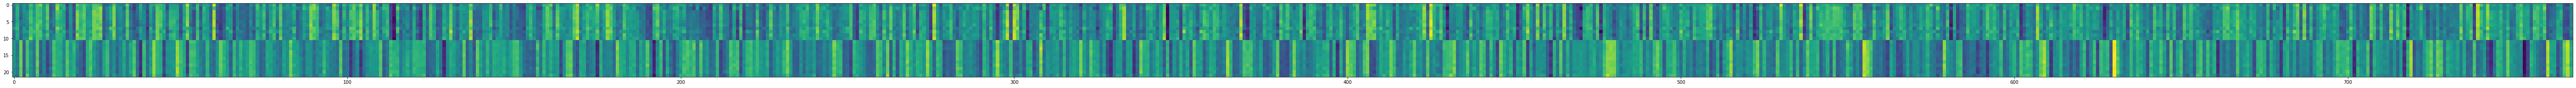

In [21]:
data_path = data_dir + '/positive_negative.tsv'
# positive negative spectrum
spectrum_data = nemo_nlp.BertSentenceClassificationDataLayer(
    input_file=data_path,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    shuffle=False,
    num_samples=-1, # lower for dev, -1 for all dataset
    batch_size=batch_size,
    dataset_type=preproc_data_layer.BertSentenceClassificationDataset
)

spectrum_input, spectrum_token_types, spectrum_attn_mask, spectrum_labels = spectrum_data()

spectrum_embeddings = bert(input_ids=spectrum_input,
                        token_type_ids=spectrum_token_types,
                        attention_mask=spectrum_attn_mask)

spectrum_embeddings_tensors = nf.infer(tensors=[spectrum_embeddings])

plt.figure(figsize=(100,100))
plt.imshow(spectrum_embeddings_tensors[0][0][:,0,:].numpy())

[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 10.342067
[t-SNE] KL divergence after 250 iterations with early exaggeration: 30.354269
[t-SNE] KL divergence after 1000 iterations: 0.002954


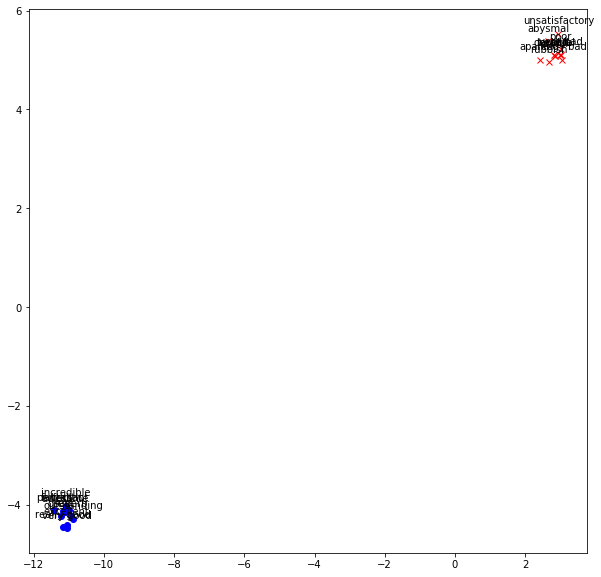

In [22]:
spectrum_df = pd.read_csv(data_path, delimiter='\t')

spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:11, 0], tsne_spectrum[0:11, 1], 'rx')
plt.plot(tsne_spectrum[11:, 0], tsne_spectrum[11:, 1], 'bo')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

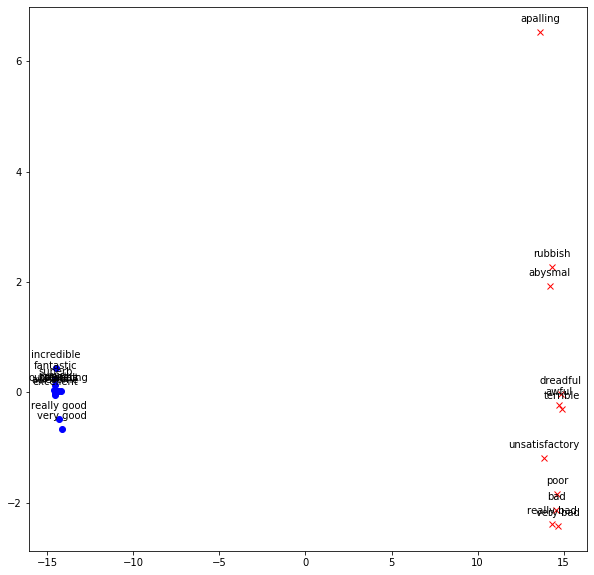

In [24]:
spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
pca_spectrum = PCA(n_components=2).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(pca_spectrum[0:11, 0], pca_spectrum[0:11, 1], 'rx')
ax.plot(pca_spectrum[11:, 0], pca_spectrum[11:, 1], 'bo')
for (x,y, label) in zip(pca_spectrum[0:, 0], pca_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center